# NYT Topic Analysis
* LDA topic generation and visualization:
    * Split raw text into n-grams and build doc-term matrix via CountVectorizer/TfidfVectorizer 
    * Generate topics on doc-term matrix
    * Create topic word clouds and pyLDAvis visualizations

In [1]:
# Modules
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
import nltk
import spacy
import gensim

import pandas as pd
import math
import numpy as np
import scipy as sp
from scipy import stats
from scipy.stats import pearsonr

from pprint import pprint
from collections import Counter
from datetime import datetime
import time
import re
import glob
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib.cm as cm
import pyLDAvis
import pyLDAvis.sklearn
from wordcloud import WordCloud
import seaborn as sns;
sns.set()

# Pandas view options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('precision', 4)

## Program Parameters

In [2]:
# Path definitions
BASE_PATH = '/Users/apelullo/Desktop/CDH/projects/nyt/'
DATA_PATH = BASE_PATH + 'data/master_data/'
OUTPUT_PATH = BASE_PATH + 'output/'
MODEL_PATH = BASE_PATH + 'models/'

CLOUD_PATH = OUTPUT_PATH + 'clouds/'
PANEL_PATH = OUTPUT_PATH + 'panels/'
TOPIC_PATH = OUTPUT_PATH + 'topics/'

In [3]:
# Custom colormaps
cdict_dark_blues = {
     'red': ((0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0)),
     'green': ((0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
     'blue': ((0.0, 0.3, 0.3),
              (1.0, 0.9, 0.9))}
dark_blues = col.LinearSegmentedColormap('my_blue_map', cdict_dark_blues, N=256, gamma=1)
cm.register_cmap(name='blue', cmap=dark_blues)

cdict_dark_reds = {
     'red': ((0.0, 0.3, 0.3),
             (1.0, 0.9, 0.9)),
     'green': ((0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
     'blue': ((0.0, 0.0, 0.0),
              (1.0, 0.0, 0.0))}
dark_reds = col.LinearSegmentedColormap('my_red_map', cdict_dark_reds, N=256, gamma=1)
cm.register_cmap(name='red', cmap=dark_reds)

## Functions

In [4]:
def get_dominant_topic(input_model,input_doc_topic):
    # column names
    topic_names = ["Topic" + str(i) for i in range(len(input_model.components_))]
    # index names
    doc_names = ["Comment" + str(i) for i in range(len(data))]

    # Make the pandas dataframe
    df_document_topic = pd.DataFrame(np.round(input_doc_topic, 2), columns=topic_names, index=doc_names)

    # Get dominant topic for each document
    dominant_topic = np.argmax(df_document_topic.values, axis=1)
    df_document_topic['dominant_topic'] = dominant_topic

    # Styling
    def color_green(val):
        color = 'green' if val > .1 else 'black'
        return 'color: {col}'.format(col=color)

    def make_bold(val):
        weight = 700 if val > .1 else 400
        return 'font-weight: {weight}'.format(weight=weight)

    # Apply Style
    df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
    return df_document_topics

## Read Data

In [5]:
# Health data
health_articles = pd.read_csv(DATA_PATH + 'health_article_data.csv')
health_comments = pd.read_csv(DATA_PATH + 'health_comment_data.csv')
health_comments = health_comments.set_index('commentID')

# Privacy data
privacy_articles = pd.read_csv(DATA_PATH + 'privacy_article_data.csv')
privacy_comments = pd.read_csv(DATA_PATH + 'privacy_comment_data.csv')
privacy_comments = privacy_comments.set_index('commentID')

### Display Data

In [6]:
print('Row Count:', len(health_articles))
print('Column Count:', len(health_articles.columns))
health_articles.head(2)

Row Count: 2
Column Count: 20


,callerID,api_timestamp,depthLimit,filter,page,replyLimit,sort,totalCommentsFound,totalCommentsReturned,totalEditorsSelectionFound,totalEditorsSelectionReturned,totalParentCommentsFound,totalParentCommentsReturned,totalRecommendationsFound,totalRecommendationsReturned,totalReplyCommentsFound,totalReplyCommentsReturned,totalReporterReplyCommentsFound,totalReporterReplyCommentsReturned,article_id
0,NaN,1564206858,2,NaN,1,3,NaN,200,26,7,0,162,25,144,13,38,1,0,0,0
1,NaN,1564206899,2,NaN,1,3,NaN,451,31,14,2,266,25,291,15,185,6,0,0,1


In [7]:
print('Row Count:', len(health_comments))
print('Column Count:', len(health_comments.columns))
health_comments.head(2)

Row Count: 581
Column Count: 25


,status,commentSequence,userID,userDisplayName,userLocation,userTitle,userURL,picURL,commentTitle,commentBody,createDate,updateDate,approveDate,recommendations,replyCount,editorsSelection,parentID,parentUserDisplayName,depth,commentType,trusted,recommendedFlag,permID,isAnonymous,article_id
commentID,,,,,,,,,,,,,,,,,,,,,,,,,
100725114,approved,100725114,0,Anne Fauvre,San Francisco,NaN,NaN,NaN,<br\//>,With new technologies I don't think this has t...,1559246362,1559250380,1559246436,1,0,False,NaN,NaN,1,comment,0,0,100725114,False,0
100675020,approved,100675020,0,michael,tristate,NaN,NaN,NaN,<br\//>,"Tsk, tsk, tsk.\n\nWhy don't you work on implem...",1558986958,1559061711,1559061711,0,0,False,NaN,NaN,1,comment,0,0,100675020,False,0


In [8]:
print('Row Count:', len(privacy_articles))
print('Column Count:', len(privacy_articles.columns))
privacy_articles.head(2)

Row Count: 94
Column Count: 20


,callerID,api_timestamp,depthLimit,filter,page,replyLimit,sort,totalCommentsFound,totalCommentsReturned,totalEditorsSelectionFound,totalEditorsSelectionReturned,totalParentCommentsFound,totalParentCommentsReturned,totalRecommendationsFound,totalRecommendationsReturned,totalReplyCommentsFound,totalReplyCommentsReturned,totalReporterReplyCommentsFound,totalReporterReplyCommentsReturned,article_id
0,NaN,1564242487,2,NaN,1,3,NaN,59,38,3,3,37,25,13,7,22,13,0,0,0
1,NaN,1564242501,2,NaN,0,3,NaN,0,0,0,0,0,0,0,0,0,0,0,0,1


In [9]:
print('Row Count:', len(privacy_comments))
print('Column Count:', len(privacy_comments.columns))
privacy_comments.head(2)

Row Count: 11555
Column Count: 25


,status,commentSequence,userID,userDisplayName,userLocation,userTitle,userURL,picURL,commentTitle,commentBody,createDate,updateDate,approveDate,recommendations,replyCount,editorsSelection,parentID,parentUserDisplayName,depth,commentType,trusted,recommendedFlag,permID,isAnonymous,article_id
commentID,,,,,,,,,,,,,,,,,,,,,,,,,
101672372,approved,101672372,0,JRB,KCMO,NaN,NaN,NaN,<br\//>,"$5 billion? Hey, somebody go over there and ge...",1564179032,1564230824,1564230824,0,0,False,NaN,NaN,1,comment,0,0,101672372,False,0
101677421,approved,101677421,0,Matt,Montreal,NaN,NaN,NaN,<br\//>,I was one of the 80 million of Anthem Blue Cr...,1564224235,1564229710,1564229710,0,0,False,NaN,NaN,1,comment,0,0,101677421,False,0


## Preprocessing

In [10]:
# Convert comments to list
data = list(privacy_comments.commentBody)
data_df = privacy_comments

In [11]:
# Remove @ references
data = [re.sub('\S*@\S*\s?', '', comment) for comment in data]
# Remove new line characters
data = [re.sub('\s+', ' ', comment) for comment in data]
# Remove distracting single quotes
data = [re.sub("\'", "", comment) for comment in data]
# Remove residual html from comments with links
data = [re.sub(r'<a.+/a>', "", comment) for comment in data]

pprint(data[0:1])

<>:2: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:4: DeprecationWarning: invalid escape sequence \s
<ipython-input-11-18fdafe585df>:2: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', comment) for comment in data]
<ipython-input-11-18fdafe585df>:4: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', comment) for comment in data]


['$5 billion? Hey, somebody go over there and get that from the coffee '
 'money...']


In [12]:
# Initialize vectorizers and transform data
ngram_low = 1
ngram_high = 3
min_df = 0.01

# Term frequency
tf_vectorizer_123gram = CountVectorizer(stop_words='english',ngram_range=(ngram_low,ngram_high),min_df=min_df)
tf_123gram_data = tf_vectorizer_123gram.fit_transform(data)
tf_123gram_names = tf_vectorizer_123gram.get_feature_names()

# Term frequency inverse document frequency
tfidf_vectorizer_123gram = TfidfVectorizer(stop_words='english',ngram_range=(ngram_low,ngram_high),min_df=min_df)
tfidf_123gram_data = tfidf_vectorizer_123gram.fit_transform(data)
tfidf_123gram_names = tfidf_vectorizer_123gram.get_feature_names()

In [13]:
# Report data shape and sparsity (pct of non-zero matrix entries)
data_dense = tf_123gram_data.todense()
print(tf_123gram_data.shape[0], 'unique documents')
print(tf_123gram_data.shape[1], 'unique terms')
print(str(((data_dense > 0).sum()/data_dense.size)*100) + "% non-zero matrix entries") 

11555 unique documents
595 unique terms
2.4960928551429227% non-zero matrix entries


## Analysis

### LDA - Manually Selecting Parameters

In [14]:
# Define model parameters
n_topics=10
max_iter=20

# Term frequency
lda_tf_model = LatentDirichletAllocation(n_components=n_topics, learning_method='batch', max_iter=max_iter, n_jobs=-1).fit(tf_123gram_data)
lda_tf_doc_topic = lda_tf_model.transform(tf_123gram_data)
lda_tf_topic_term = lda_tf_model.components_
lda_tf_score = lda_tf_model.score(tf_123gram_data)
lda_tf_perplexity = lda_tf_model.perplexity(tf_123gram_data)

# Term frequency inverse document frequency
lda_tfidf_model = LatentDirichletAllocation(n_components=n_topics, learning_method='batch', max_iter=max_iter, n_jobs=-1).fit(tfidf_123gram_data)
lda_tfidf_doc_topic = lda_tfidf_model.transform(tfidf_123gram_data)
lda_tfidf_topic_term = lda_tfidf_model.components_
lda_tfidf_score = lda_tfidf_model.score(tfidf_123gram_data)
lda_tfidf_perplexity = lda_tfidf_model.perplexity(tfidf_123gram_data)

In [15]:
# Report built-in model scores
measures = [[lda_tf_score,lda_tf_perplexity],[lda_tfidf_score,lda_tfidf_perplexity]]
measures_df = pd.DataFrame(measures, columns=['Log Likeihood', 'Perplexity'], index=['tf','tf_idf'])
measures_df

,Log Likeihood,Perplexity
tf,-1.2459e+06,426.1930
tf_idf,-2.7681e+05,1335.2689


### LDA - Grid Searching Parameters

In [16]:
# Define model parameters and parameters to grid search
max_iter = 20
search_params = {'n_components': [5, 10, 15, 20, 25], 'learning_decay': [.5, .7, .9]}

# Initialize lda base models and grid objects and search params to find best model
lda_tf_base = LatentDirichletAllocation(learning_method='batch', max_iter=max_iter, n_jobs=-1)
lda_tf_grid = GridSearchCV(lda_tf_base, param_grid=search_params).fit(tf_123gram_data)

lda_tfidf_base = LatentDirichletAllocation(learning_method='batch', max_iter=max_iter, n_jobs=-1)
lda_tfidf_grid = GridSearchCV(lda_tfidf_base, param_grid=search_params).fit(tfidf_123gram_data)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [17]:
# Term frequency
lda_tf_model = lda_tf_grid.best_estimator_
lda_tf_doc_topic = lda_tf_model.transform(tf_123gram_data)
lda_tf_topic_term = lda_tf_model.components_
lda_tf_score = lda_tf_model.score(tf_123gram_data)
lda_tf_perplexity = lda_tf_model.perplexity(tf_123gram_data)

# Term frequency inverse document frequency
lda_tfidf_model = lda_tfidf_grid.best_estimator_
lda_tfidf_doc_topic = lda_tfidf_model.transform(tfidf_123gram_data)
lda_tfidf_topic_term = lda_tfidf_model.components_
lda_tfidf_score = lda_tfidf_model.score(tfidf_123gram_data)
lda_tfidf_perplexity = lda_tfidf_model.perplexity(tfidf_123gram_data)

In [18]:
print('Term Frequency:')
print("\tBest Model Params: ", lda_tf_grid.best_params_)
print("\tBest Log Likelihood Score: ", lda_tf_grid.best_score_)
print("\tModel Log Likelihood Score: ", lda_tf_score)
print("\tModel Perplexity: ", lda_tf_perplexity)

Term Frequency:
	Best Model Params:  {'learning_decay': 0.5, 'n_components': 5}
	Best Log Likelihood Score:  -424158.3946985652
	Model Log Likelihood Score:  -1243413.188660797
	Model Perplexity:  421.141143088046


In [19]:
print('Term Frequency Inverse Document Frequency:')
print("\tBest Model Params: ", lda_tfidf_grid.best_params_)
print("\tBest Log Likelihood Score: ", lda_tfidf_grid.best_score_)
print("\tModel Log Likelihood Score: ", lda_tfidf_score)
print("\tModel Perplexity: ", lda_tfidf_perplexity)

Term Frequency Inverse Document Frequency:
	Best Model Params:  {'learning_decay': 0.7, 'n_components': 5}
	Best Log Likelihood Score:  -92005.05803188718
	Model Log Likelihood Score:  -263146.72747304343
	Model Perplexity:  936.0959641578041


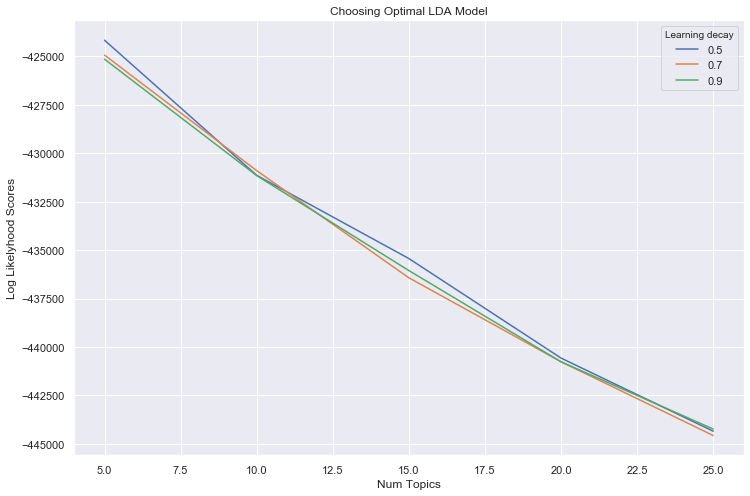

In [20]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [5, 10, 15, 20, 25]
log_likelyhoods_5 = lda_tf_grid.cv_results_['mean_test_score'][0:5]
log_likelyhoods_7 = lda_tf_grid.cv_results_['mean_test_score'][5:10]
log_likelyhoods_9 = lda_tf_grid.cv_results_['mean_test_score'][10:15]

# Plot
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

## Topic Exploration

### Create DataFrames

In [21]:
# Doc-Topic DataFrame
tf_doc_topic = pd.DataFrame(lda_tf_doc_topic, 
                            columns=['Topic'+str(i) for i in range(len(lda_tf_doc_topic[0]))], 
                            index=data_df.index)
tf_doc_topic['dominant_topic'] = np.argmax(tf_doc_topic.values, axis=1)

In [22]:
# Topic Term DataFrame
tf_term_topic = pd.DataFrame(lda_tf_topic_term,
            index=['Topic'+str(i) for i in range(len(lda_tf_topic_term))],
            columns=tf_123gram_names).transpose()

In [23]:
# Doc-Topic DataFrame
tfidf_doc_topic = pd.DataFrame(lda_tfidf_doc_topic, 
                            columns=['Topic'+str(i) for i in range(len(lda_tfidf_doc_topic[0]))], 
                            index=data_df.index)
tfidf_doc_topic['dominant_topic'] = np.argmax(tfidf_doc_topic.values, axis=1)

In [24]:
# Topic Term DataFrame
tfidf_term_topic = pd.DataFrame(lda_tfidf_topic_term,
            index=['Topic'+str(i) for i in range(len(lda_tfidf_topic_term))],
            columns=tfidf_123gram_names).transpose()

### Dominant Topic

In [25]:
# Styled Output
tf_dominant_topic = get_dominant_topic(lda_tf_model,lda_tf_doc_topic)
tfidf_dominant_topic = get_dominant_topic(lda_tfidf_model,lda_tfidf_doc_topic)

In [26]:
tf_dominant_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Comment0,0.07,0.07,0.07,0.07,0.73,4
Comment1,0.01,0.33,0.01,0.31,0.34,4
Comment2,0.01,0.14,0.01,0.37,0.47,4
Comment3,0.2,0.02,0.02,0.02,0.73,4
Comment4,0.21,0.02,0.02,0.02,0.74,4
Comment5,0.32,0.02,0.02,0.02,0.62,4
Comment6,0.03,0.03,0.03,0.03,0.9,4
Comment7,0.01,0.01,0.01,0.01,0.97,4
Comment8,0.01,0.01,0.01,0.44,0.52,4
Comment9,0.1,0.28,0,0.22,0.39,4


In [27]:
# Topic counts
tf_doc_topic.dominant_topic.value_counts()

0    3368
2    2534
4    2242
3    1890
1    1521
Name: dominant_topic, dtype: int64

In [28]:
tfidf_dominant_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Comment0,0.08,0.08,0.08,0.66,0.08,3
Comment1,0.87,0.03,0.03,0.03,0.03,0
Comment2,0.57,0.31,0.04,0.04,0.04,0
Comment3,0.05,0.53,0.05,0.31,0.05,1
Comment4,0.05,0.81,0.05,0.05,0.05,1
Comment5,0.06,0.77,0.06,0.06,0.06,1
Comment6,0.06,0.06,0.06,0.77,0.06,3
Comment7,0.06,0.06,0.06,0.77,0.05,3
Comment8,0.05,0.05,0.05,0.81,0.05,3
Comment9,0.86,0.03,0.03,0.03,0.03,0


In [29]:
# Topic counts
tfidf_doc_topic.dominant_topic.value_counts()

4    3112
1    2756
0    2499
2    1859
3    1329
Name: dominant_topic, dtype: int64

### Topic Visualizations

#### Term Frequency

In [30]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tf_model, tf_123gram_data, tf_vectorizer_123gram, mds='tsne')
panel

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=             x         y  topics  cluster     Freq
topic                                             
0     -34.8445  -85.5198       1        1  25.2863
4     -89.5273  -13.4260       2        1  22.7476
2      -8.6161   33.6489       3        1  20.0511
3      66.0880  -16.9426       4        1  17.0246
1      52.3933 -109.5448       5        1  14.8903, topic_info=    Category       Freq                  Term      Total  loglift  logprob
140  Default  3092.0000                  data  3092.0000  30.0000  30.0000
213  Default  1701.0000                google  1701.0000  29.0000  29.0000
216  Default  1416.0000            government  1416.0000  28.0000  28.0000
326  Default   981.0000                 media   981.0000  27.0000  27.0000
18   Default   693.0000                   ads   693.0000  26.0000  26.0000
183  Default  2702.0000              facebook  2702.0000  25.0000  25.0000
377  Default  1351.0000                 phone  1351.0000  24.0000  24.0000
510  Default  1036.0000            technology  1036.0000  23.0000  23.0000
106  Default  1456.0000             companies  1456.0000  22.0000  22.0000
259  Default   593.0000             insurance   593.0000  21.0000  21.0000
476  Default  1178.0000                social  1178.0000  20.0000  20.0000
477  Default   732.0000          social media   732.0000  19.0000  19.0000
256  Default  1675.0000           information  1675.0000  18.0000  18.0000
155  Default   511.0000                   dna   511.0000  17.0000  17.0000
229  Default   500.0000                health   500.0000  16.0000  16.0000
160  Default  2251.0000                  dont  2251.0000  15.0000  15.0000
240  Default   632.0000                 human   632.0000  14.0000  14.0000
35   Default   540.0000                 apple   540.0000  13.0000  13.0000
500  Default   646.0000          surveillance   646.0000  12.0000  12.0000
548  Default  2075.0000                   use  2075.0000  11.0000  11.0000
508  Default   875.0000                  tech   875.0000  10.0000  10.0000
423  Default   492.0000           recognition   492.0000   9.0000   9.0000
385  Default   717.0000                police   717.0000   8.0000   8.0000
184  Default   468.0000                facial   468.0000   7.0000   7.0000
571  Default   439.0000                 women   439.0000   6.0000   6.0000
34   Default   394.0000                   app   394.0000   5.0000   5.0000
88   Default   438.0000                 china   438.0000   4.0000   4.0000
397  Default  3393.0000               privacy  3393.0000   3.0000   3.0000
36   Default   383.0000                  apps   383.0000   2.0000   2.0000
450  Default   547.0000                search   547.0000   1.0000   1.0000
326   Topic1   980.6218                 media   981.4779   1.3740  -3.9714
477   Topic1   732.0956          social media   732.9055   1.3738  -4.2637
202   Topic1   404.5055               friends   405.4234   1.3726  -4.8569
366   Topic1   273.8438               parents   275.2227   1.3699  -5.2470
272   Topic1   307.4528                  kids   309.7553   1.3674  -5.1312
320   Topic1   192.6789                  mark   195.3361   1.3612  -5.5985
220   Topic1   152.7717                   guy   161.8598   1.3171  -5.8306
589   Topic1   245.8559             years ago   264.6443   1.3013  -5.3548
201   Topic1   127.3128                friend   141.4383   1.2697  -6.0129
449   Topic1   154.0058                screen   173.9131   1.2533  -5.8226
543   Topic1   183.3292                    tv   209.5202   1.2414  -5.6483
22    Topic1   391.7667                   ago   449.7065   1.2370  -4.8889
87    Topic1   278.3322              children   320.9862   1.2323  -5.2308
476   Topic1  1012.0662                social  1178.3007   1.2228  -3.9398
227   Topic1   114.2996                  hate   135.4172   1.2054  -6.1207
378   Topic1   305.0038                phones   377.9286   1.1605  -5.1392
475   Topic1   216.2839                 smart   270.1160   1.1526  -5.4830


#### Term Frequency Inverse Documnet Frequency

In [31]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_tfidf_model, tfidf_123gram_data, tfidf_vectorizer_123gram, mds='tsne')
panel

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=            x        y  topics  cluster     Freq
topic                                           
4     -9.0576  18.1955       1        1  24.2345
1     -6.6909  28.7564       2        1  23.4522
0      2.3866  18.4500       3        1  22.3609
2      8.0450  27.8466       4        1  16.2837
3      1.0805  36.6747       5        1  13.6687, topic_info=    Category      Freq                 Term     Total  loglift  logprob
183  Default  390.0000             facebook  390.0000  30.0000  30.0000
326  Default  159.0000                media  159.0000  29.0000  29.0000
477  Default  125.0000         social media  125.0000  28.0000  28.0000
476  Default  177.0000               social  177.0000  27.0000  27.0000
213  Default  246.0000               google  246.0000  26.0000  26.0000
377  Default  211.0000                phone  211.0000  25.0000  25.0000
385  Default  132.0000               police  132.0000  24.0000  24.0000
155  Default  106.0000                  dna  106.0000  23.0000  23.0000
189  Default  110.0000                   fb  110.0000  22.0000  22.0000
423  Default   94.0000          recognition   94.0000  21.0000  21.0000
184  Default   90.0000               facial   90.0000  20.0000  20.0000
571  Default   90.0000                women   90.0000  19.0000  19.0000
594  Default   80.0000           zuckerberg   80.0000  18.0000  18.0000
185  Default   80.0000   facial recognition   80.0000  17.0000  17.0000
140  Default  347.0000                 data  347.0000  16.0000  16.0000
18   Default  122.0000                  ads  122.0000  15.0000  15.0000
132  Default   72.0000                crime   72.0000  14.0000  14.0000
35   Default   98.0000                apple   98.0000  13.0000  13.0000
259  Default  101.0000            insurance  101.0000  12.0000  12.0000
328  Default   67.0000                  men   67.0000  11.0000  11.0000
320  Default   56.0000                 mark   56.0000  10.0000  10.0000
216  Default  211.0000           government  211.0000   9.0000   9.0000
513  Default   86.0000                thank   86.0000   8.0000   8.0000
239  Default   51.0000               hughes   51.0000   7.0000   7.0000
106  Default  188.0000            companies  188.0000   6.0000   6.0000
88   Default   90.0000                china   90.0000   5.0000   5.0000
194  Default   74.0000                 fine   74.0000   4.0000   4.0000
135  Default   49.0000            criminals   49.0000   3.0000   3.0000
347  Default   78.0000                 news   78.0000   2.0000   2.0000
63   Default   62.0000                break   62.0000   1.0000   1.0000
272   Topic1   57.3701                 kids   58.1930   1.4032  -5.0905
366   Topic1   49.4450              parents   50.9286   1.3878  -5.2392
589   Topic1   49.3757            years ago   52.4086   1.3578  -5.2406
449   Topic1   33.6387               screen   36.9995   1.3222  -5.6244
201   Topic1   28.3022               friend   31.8857   1.2982  -5.7971
81    Topic1   41.6588                 cell   47.8850   1.2781  -5.4105
378   Topic1   63.0500               phones   72.7585   1.2742  -4.9961
22    Topic1   67.0319                  ago   78.8116   1.2555  -4.9349
543   Topic1   38.5991                   tv   45.5303   1.2522  -5.4868
475   Topic1   49.0805                smart   58.0351   1.2498  -5.2466
377   Topic1  174.1071                phone  211.9772   1.2206  -3.9804
75    Topic1   55.8433                  car   69.8120   1.1941  -5.1175
561   Topic1   41.7844                watch   52.3710   1.1916  -5.4075
87    Topic1   49.3289             children   64.1037   1.1554  -5.2415
483   Topic1   24.8799                sorry   32.3436   1.1550  -5.9260
592   Topic1   29.5149                young   38.5933   1.1492  -5.7551
314   Topic1   60.6128                 love   80.2312   1.1370  -5.0355
269   Topic1   47.3144                  ive   62.8649   1.1332  -5.2832
562   Topic1   30.1786             watching   40.6226   1.1202  -5.7329
310   Topic1  

### Top Words

#### Term Frequency

In [32]:
tf_top_words = []
tf_top_words_val = []

for topic in tf_term_topic.columns:
    temp = tf_term_topic[topic].sort_values(ascending=False,)
    
    words = temp.index.values
    tf_top_words.append(words)
    
    values = temp.values
    tf_top_words_val.append(values)

In [33]:
tf_top_words_df = pd.DataFrame(tf_top_words,
             index=['Topic'+str(i) for i in range(len(lda_tf_topic_term))],
             columns=['Word'+str(i) for i in range(len(tf_123gram_names))]).transpose()

In [34]:
tf_top_words_df.head(20)

,Topic0,Topic1,Topic2,Topic3,Topic4
Word0,people,data,people,google,privacy
Word1,social,information,technology,use,data
Word2,media,dont,like,ads,facebook
Word3,facebook,insurance,human,dont,government
Word4,dont,dna,surveillance,phone,companies
Word5,just,health,privacy,apple,information
Word6,like,people,police,privacy,tech
Word7,time,know,recognition,facebook,personal
Word8,phone,want,just,like,business
Word9,social media,just,facial,search,free


#### Term Frequency Inverse Document Frequency

In [35]:
tfidf_top_words = []
tfidf_top_words_val = []

for topic in tfidf_term_topic.columns:
    temp = tfidf_term_topic[topic].sort_values(ascending=False,)
    
    words = temp.index.values
    tfidf_top_words.append(words)
    
    values = temp.values
    tfidf_top_words_val.append(values)

In [36]:
tfidf_top_words_df = pd.DataFrame(tfidf_top_words,
             index=['Topic'+str(i) for i in range(len(lda_tfidf_topic_term))],
             columns=['Word'+str(i) for i in range(len(tfidf_123gram_names))]).transpose()

In [37]:
tfidf_top_words_df.head(20)

,Topic0,Topic1,Topic2,Topic3,Topic4
Word0,data,privacy,police,facebook,phone
Word1,google,government,dna,media,people
Word2,use,people,recognition,social,dont
Word3,information,insurance,facial,social media,just
Word4,privacy,right,women,fb,like
Word5,ads,tech,facial recognition,zuckerberg,know
Word6,facebook,companies,technology,good,im
Word7,apple,big,people,mark,years
Word8,companies,data,crime,news,time
Word9,free,china,thank,fine,read


### Top Comments

#### Term Frequency

In [38]:
tf_top_comments = []
tf_top_comments_val = []

for topic in tf_doc_topic.columns[0:-1]:
    temp = tf_doc_topic[topic].sort_values(ascending=False,)
    
    comments = temp.index.values
    tf_top_comments.append(comments)
    
    lda_values = temp.values
    tf_top_comments_val.append(lda_values)

In [39]:
tf_top_comments_df = pd.DataFrame(tf_top_comments,
             index=['Topic'+str(i) for i in range(len(lda_tf_doc_topic[0]))],
             columns=['Comment'+str(i) for i in range(len(lda_tf_doc_topic))]).transpose()

In [40]:
comment_dict = dict(zip(data_df.index.values, data))
def get_comment_body(val):
    return comment_dict[val]

tf_top_comments_df.applymap(get_comment_body)

,Topic0,Topic1,Topic2,Topic3,Topic4
Comment0,Taylor I think the point is that parents are m...,"Mr. Miner, as a physician-scientist, I work wi...",So many misguided comments here it’s difficult...,"If you willingly use ""services"" like Google, F...",When Congress declared in 2017 that it was leg...
Comment1,I dont think anyone is saying that parents don...,All of the information that is harvested about...,I’m getting tired of these alarmist articles t...,"This presentation is so full of, at best, misl...","There is a way to break up the ""natural monopo..."
Comment2,Madonna is wrong. 30 years ago I remember pla...,The basic purpose of insurance is to pool the ...,America doesnt face a rising crime rate. It fa...,"This presentation is so full of, at best, misl...",(1) There is no privacy regulatory authority i...
Comment3,"So the Times has finally caught up with the ""t...",How about if the law uses AI against the AI-er...,Future of human privacy with advance of comput...,Nice article. The issues on privacy are largel...,Click through agreements and EULAs dis-empower...
Comment4,"Im 73, and love my cell phone; its a great too...","Like the author, I, too, am fastidious about m...",No one really understands the internet and wha...,Google has bots that scan all the text in your...,“The second misunderstanding is of antitrust l...
Comment5,In the past year Ive stopped all kind of socia...,Privacy is a means of self defense. I dont wan...,Anyone who believes this technology will be us...,"- regarding targeted ads, theres something tha...",To protect privacy we have to fight back again...
Comment6,"Sure, there are lots of potential hazards from...",Jackson - because I dont want my personal conv...,The elephant in the room left unaddressed by t...,"I set all the highest privacy settings Google,...","Important points are made here, regarding the ..."
Comment7,Raise your hand if you read the Facebook News ...,"An AI is a machine, and as such, it should be ...",I think this is correct. Especially anyone who...,Too bad we cant post graphics here because thi...,"If you want to end the privacy debate, then th..."
Comment8,This happened around 10 yrs ago. I was at a di...,My real concern is not that these systems will...,"The future of the internet/computers, problems...",- while it is true NYT does some of the tracki...,As the information network in which humanity i...
Comment9,I think youre being a little defensive. is ac...,While I personally could support anonymous dat...,I guess Japan is a far safer place than PRC fo...,The reality is that we love google and instagr...,And now these same companies are trying to use...


#### Term Frequency Inverse Document Frequency

In [41]:
tfidf_top_comments = []
tfidf_top_comments_val = []

for topic in tfidf_doc_topic.columns[0:-1]:
    temp = tfidf_doc_topic[topic].sort_values(ascending=False,)
    
    comments = temp.index.values
    tfidf_top_comments.append(comments)
    
    lda_values = temp.values
    tfidf_top_comments_val.append(lda_values)

In [42]:
tfidf_top_comments_df = pd.DataFrame(tfidf_top_comments,
             index=['Topic'+str(i) for i in range(len(lda_tfidf_doc_topic[0]))],
             columns=['Comment'+str(i) for i in range(len(lda_tfidf_doc_topic))]).transpose()

In [43]:
comment_dict = dict(zip(data_df.index.values, data))
def get_comment_body(val):
    return comment_dict[val]

tfidf_top_comments_df.applymap(get_comment_body)

,Topic0,Topic1,Topic2,Topic3,Topic4
Comment0,"Id say capitalism services privacy just fine, ...",Yes! We should stop fetishizing privacy and re...,Does this histrionic & absurd opposition to f...,"""But the biggest winners would be the American...","Thank you, Ms. Swisher, for writing this piece..."
Comment1,Selling or using personal data to push product...,The Orwellian nightmare begins when someone cl...,Does this histrionic & absurd opposition to fa...,Kudos to Chris Hughes for penning the most wel...,"Im 73, and love my cell phone; its a great too..."
Comment2,"""Sun Microsystems co-founder Scott McNealy ......",There are several problems with the sharing ap...,Does this histrionic & absurd opposition to fa...,I just dont get it. I use FB simply as a blog ...,"My mother died four months ago today, and her ..."
Comment3,Until the leaders of both political parties ha...,"Thank you, Mr. Wu, for this insightful article...",Does this histrionic opposition to facial reco...,What will breaking them up do? Why didnt any c...,"Ah, the complexity of the world we live in. I ..."
Comment4,I laughed out loud at the first sentence. You ...,Modern America equates privacy with loneliness...,Does this histrionic opposition to facial reco...,I dont think Zuckerberg needs someone to come ...,This is frightening. My phone and tablet are l...
Comment5,While I agree with the author that there needs...,Because of obligations to owners and stockhold...,So many misguided comments here it’s difficult...,"Here is an easy fix, get rid of Facebook. Show...",There are very serious concerns regarding priv...
Comment6,The internet bubble burst in 2000 as we learne...,The modern world and society are built on the ...,It seems like every day brings a new quote in ...,"I respect the opinion of Mr. Hughes, even thou...","Being online excessively, with lots of friends..."
Comment7,The problem is There Ain’t No Such Thing As A ...,"Like the author, I, too, am fastidious about m...",Why try to solve crimes when it is so much mor...,Facebook has become Pandoras box. A spin-off o...,Yes. It is a complex area. On the one hand I v...
Comment8,I have been in the IT data world for 30+ years...,"Why should Americans feel the way they do, tha...",Why try to solve crimes when it is so much mor...,"Like any monopoly or oligopoly, it is not a go...",When going through my parents’ house after my ...
Comment9,People try to scaremonger about online data bu...,If we care so much about our privacy in Americ...,Brown Actually the overwhelming majority of Am...,With all respect: the author of this article -...,I see a potential new pastime: algorithm skewi...


### Visualizations

#### Term Frequency

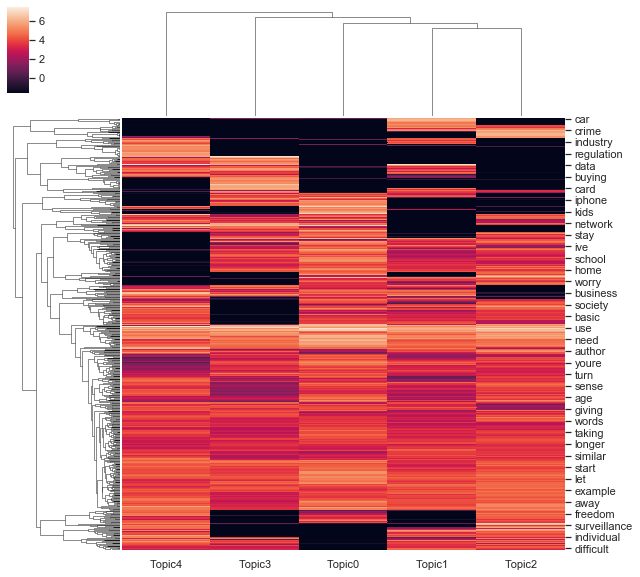

In [44]:
def log(val):
    return math.log(val)

sns.clustermap(tf_term_topic.applymap(log))

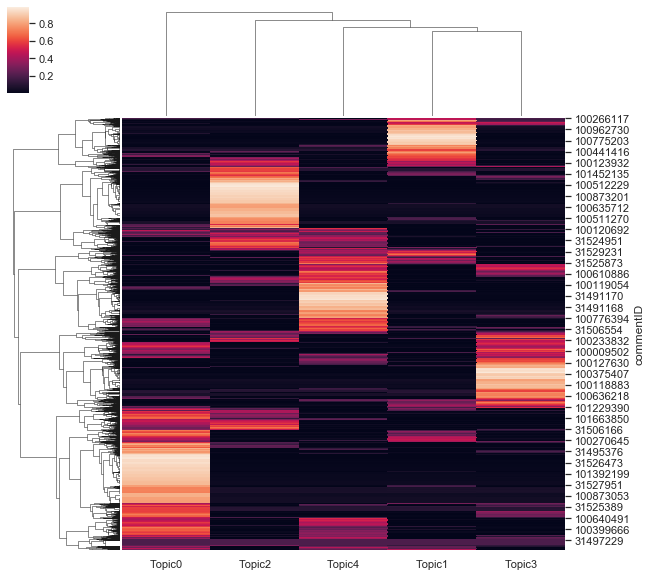

In [45]:
sns.clustermap(tf_doc_topic.iloc[:,:-1])

#### Term Frequency Inverse Document Frequency

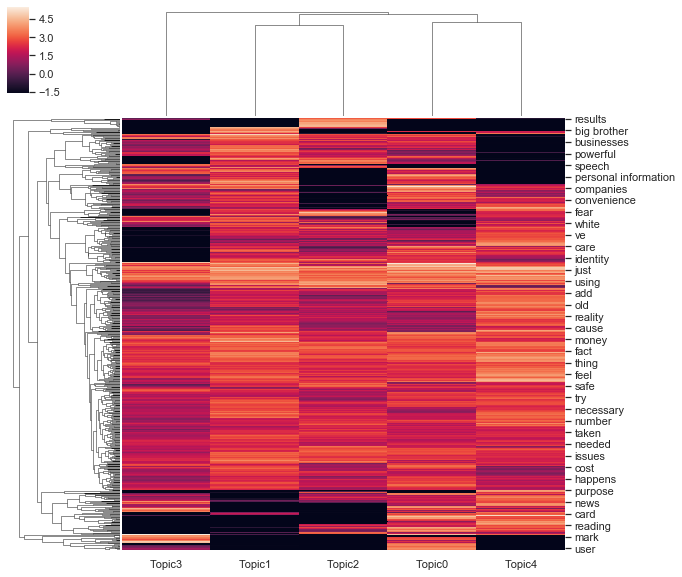

In [46]:
def log(val):
    return math.log(val)

sns.clustermap(tfidf_term_topic.applymap(log))

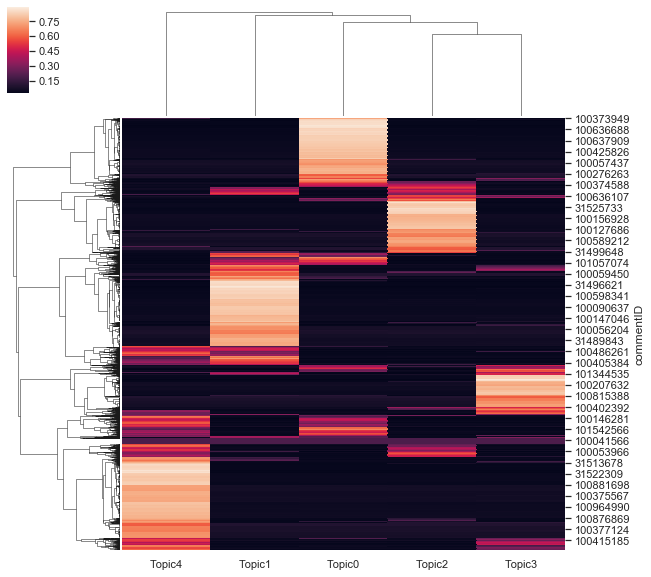

In [47]:
sns.clustermap(tfidf_doc_topic.iloc[:,:-1])

### K-Means

#### Term Frequency

In [48]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_tf_doc_topic)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_tf_doc_topic)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.7   0.24  0.44  0.31  0.4 ]
 [-0.64  0.14  0.72  0.11  0.17]]
Perc of Variance Explained: 
 [0.04 0.31]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

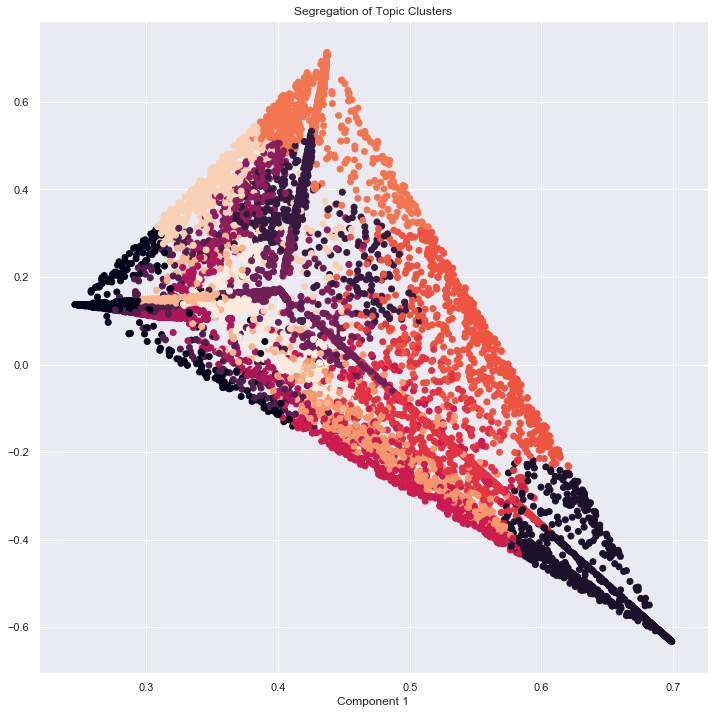

In [49]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

#### Term Frequency Inverse Document Frequency

In [50]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_tfidf_doc_topic)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_tfidf_doc_topic)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.44  0.52  0.32  0.26  0.6 ]
 [ 0.07  0.73  0.01  0.   -0.68]]
Perc of Variance Explained: 
 [0.02 0.32]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

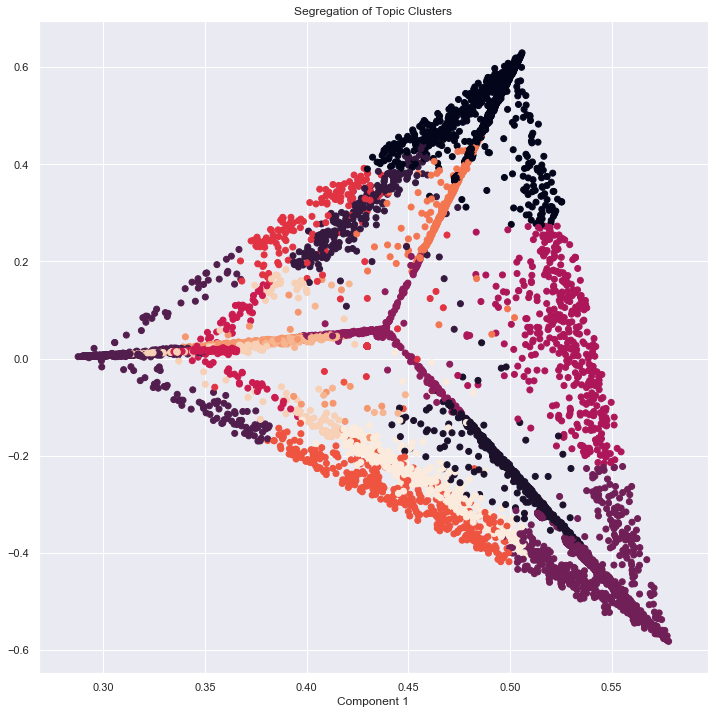

In [51]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

### Correlation with Recommendations

#### Term Frequency

In [53]:
num_topics = len(tf_term_topic.columns)
tf_doc_topic = tf_doc_topic.merge(data_df[['recommendations']],left_index=True, right_index=True)
tf_topic_recc_corr = tf_doc_topic.corr().iloc[0:num_topics,-1].values

In [54]:
tf_doc_topic.corr()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic,recommendations_x,recommendations_y
Topic0,1.0000,-0.2707,-0.3399,-0.2718,-0.2841,-0.6752,0.0205,0.0205
Topic1,-0.2707,1.0000,-0.1941,-0.1793,-0.2052,-0.2012,0.0057,0.0057
Topic2,-0.3399,-0.1941,1.0000,-0.2685,-0.2720,0.0452,-0.0047,-0.0047
Topic3,-0.2718,-0.1793,-0.2685,1.0000,-0.1882,0.3082,-0.0276,-0.0276
Topic4,-0.2841,-0.2052,-0.2720,-0.1882,1.0000,0.6239,0.0027,0.0027
dominant_topic,-0.6752,-0.2012,0.0452,0.3082,0.6239,1.0000,-0.0161,-0.0161
recommendations_x,0.0205,0.0057,-0.0047,-0.0276,0.0027,-0.0161,1.0000,1.0000
recommendations_y,0.0205,0.0057,-0.0047,-0.0276,0.0027,-0.0161,1.0000,1.0000


#### Term Frequency Inverse Document Frequency

In [58]:
num_topics = len(tf_term_topic.columns)
tfidf_doc_topic = tfidf_doc_topic.merge(data_df[['recommendations']],left_index=True, right_index=True)
tfidf_topic_recc_corr = tfidf_doc_topic.corr().iloc[0:num_topics,-1].values

In [59]:
tfidf_doc_topic.corr()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic,recommendations_x,recommendations_y
Topic0,1.0000,-0.2981,-0.2377,-0.1960,-0.3110,-0.6220,-0.0141,-0.0141
Topic1,-0.2981,1.0000,-0.2519,-0.2123,-0.3444,-0.3468,0.0175,0.0175
Topic2,-0.2377,-0.2519,1.0000,-0.1574,-0.2541,0.0118,-0.0077,-0.0077
Topic3,-0.1960,-0.2123,-0.1574,1.0000,-0.1989,0.2344,-0.0104,-0.0104
Topic4,-0.3110,-0.3444,-0.2541,-0.1989,1.0000,0.7569,0.0101,0.0101
dominant_topic,-0.6220,-0.3468,0.0118,0.2344,0.7569,1.0000,0.0176,0.0176
recommendations_x,-0.0141,0.0175,-0.0077,-0.0104,0.0101,0.0176,1.0000,1.0000
recommendations_y,-0.0141,0.0175,-0.0077,-0.0104,0.0101,0.0176,1.0000,1.0000


### Top Comments for Coding

In [60]:
# Temp
temp = tf_top_comments_df.head(20).values
idx = set([item for row in temp for item in row])
top_comments_temp = data_df[data_df.index.isin(idx)]
#top_comments_temp.to_csv('/Users/apelullo/Desktop/'+'tf_top_comment.csv')

In [61]:
# Temp
temp = tfidf_top_comments_df.head(20).values
idx = set([item for row in temp for item in row])
top_comments_temp = data_df[data_df.index.isin(idx)]
#top_comments_temp.to_csv('/Users/apelullo/Desktop/'+'tfidf_top_comment.csv')

## Word Clouds

#### Term Frequency

In [62]:
# Get dictionaries of term prevalence in each topic
num_topics = len(tf_term_topic.columns)
word_count=20
tf_topic_dict = []

for topic in tf_term_topic.columns:
    temp = tf_term_topic[topic].sort_values(ascending=False)[0:20]
    keys = temp.index.values
    values = temp.values
    tf_topic_dict.append(dict(zip(keys,values)))

In [63]:
# Create topic word clouds, scaling terms by topic prevalence
tf_clouds = []

for i in range(num_topics):
    if tf_topic_recc_corr[i] >= 0:
        color_map = dark_blues
    else:
        color_map = dark_reds  
    tf_clouds.append((WordCloud(width=500, height=500, prefer_horizontal=1, background_color='white', relative_scaling=0.7, colormap=color_map).generate_from_frequencies(frequencies=tf_topic_dict[i], max_font_size=None),tf_topic_recc_corr[i]))

tf_clouds.sort(key=lambda x: x[1])

In [64]:
# Save word clouds
for i in range(num_topics):
    name = CLOUD_PATH + 'tf_cloud_topic' + str(i) + '.png'
    tf_clouds[i][0].to_file(name)

#### Term Frequency Inverse Document Frequency

In [65]:
# Get dictionaries of term prevalence in each topic
num_topics = len(tfidf_term_topic.columns)
word_count=20
tfidf_topic_dict = []

for topic in tfidf_term_topic.columns:
    temp = tfidf_term_topic[topic].sort_values(ascending=False)[0:20]
    keys = temp.index.values
    values = temp.values
    tfidf_topic_dict.append(dict(zip(keys,values)))

In [66]:
# Create topic word clouds, scaling terms by topic prevalence
tfidf_clouds = []

for i in range(num_topics):
    if tfidf_topic_recc_corr[i] >= 0:
        color_map = dark_blues
    else:
        color_map = dark_reds  
    tfidf_clouds.append((WordCloud(width=500, height=500, prefer_horizontal=1, background_color='white', relative_scaling=0.7, colormap=color_map).generate_from_frequencies(frequencies=tfidf_topic_dict[i], max_font_size=None),tfidf_topic_recc_corr[i]))

tfidf_clouds.sort(key=lambda x: x[1])

In [67]:
# Save word clouds
for i in range(num_topics):
    name = CLOUD_PATH + 'tfidf_cloud_topic' + str(i) + '.png'
    tfidf_clouds[i][0].to_file(name)

In [73]:
tf_doc_topic.corr()

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic,recommendations_x,recommendations_y
Topic0,1.0000,-0.2707,-0.3399,-0.2718,-0.2841,-0.6752,0.0205,0.0205
Topic1,-0.2707,1.0000,-0.1941,-0.1793,-0.2052,-0.2012,0.0057,0.0057
Topic2,-0.3399,-0.1941,1.0000,-0.2685,-0.2720,0.0452,-0.0047,-0.0047
Topic3,-0.2718,-0.1793,-0.2685,1.0000,-0.1882,0.3082,-0.0276,-0.0276
Topic4,-0.2841,-0.2052,-0.2720,-0.1882,1.0000,0.6239,0.0027,0.0027
dominant_topic,-0.6752,-0.2012,0.0452,0.3082,0.6239,1.0000,-0.0161,-0.0161
recommendations_x,0.0205,0.0057,-0.0047,-0.0276,0.0027,-0.0161,1.0000,1.0000
recommendations_y,0.0205,0.0057,-0.0047,-0.0276,0.0027,-0.0161,1.0000,1.0000


In [72]:
tf_doc_topic['recommendations_x'].apply(lambda x: 1 if x > 0 else 0)

commentID
101672372    0
101677421    0
101671021    0
101668697    0
101670849    0
101671051    0
101669467    0
101669446    1
101660050    1
101668387    1
101669722    1
101660370    1
101661672    1
101665091    1
101669534    0
101665842    0
101666413    0
101666450    0
101667006    0
101666674    1
101667316    0
101667630    0
101662322    1
101664949    0
101667204    0
101676710    0
101667827    0
101667045    0
101666374    1
101665734    1
101665750    1
101667058    1
101668083    1
101665946    1
101665366    1
101667085    0
101665081    0
101664998    1
101664946    0
101667143    0
101657616    0
101659046    1
101660068    0
101657834    0
101664211    1
101663495    1
101662372    1
101663850    1
101663521    0
101660266    1
101663386    0
101665168    0
101659956    0
101658297    1
101665206    0
101658229    1
101660087    1
101581321    1
101582811    1
101583333    1
101582309    1
101580481    1
101582419    1
101580455    1
101580996    1
101581855    1
